In [84]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, max_error
from xgboost import XGBRegressor
import pickle

In [2]:
harmony_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\Harmony_data.csv')
IHS_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\IHS_data.csv')
train_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\production_data_train.csv', parse_dates=[['Month', 'Year']])

harmony_data.shape, IHS_data.shape, train_data.shape

((8930, 7), (9224, 14), (394074, 9))

In [3]:
train_data.rename(columns={'Month_Year':'Date'}, inplace=True)

In [4]:
train_data.set_index('Date', inplace=True)

In [5]:
IHS = IHS_data.drop_duplicates(subset=['API'])

In [6]:
for column in IHS.columns:
    train_data[column] = train_data['API'].map(dict(zip(IHS.API, IHS[column])))

for column in harmony_data.columns:
    train_data[column] = train_data['API'].map(dict(zip(harmony_data.API, harmony_data[column])))


In [7]:
df = train_data.drop(['_LastUpdate', 'PermitDate', 'SpudDate', 'CompletionDate','FirstProductionDate'], axis=1)

In [8]:
df['API'] = df.API.astype(str)

In [9]:
for label, content in df.items():
    if content.dtype == 'object':
        df[label] = pd.Categorical(content).codes

In [10]:
df_date = pd.DataFrame(columns=df.columns)
for well in df.API.unique():
    order = df[(df['API'] == well)].sort_values(by='Date')
    df_date = pd.concat([df_date, order], axis=0)

In [11]:
df_date['Liquid'] = df_date.Liquid.astype(int)

In [12]:
df_date.index.name = 'Date'

In [13]:
df_date['API+I'] = df_date.index.astype(str) + df_date.API.astype(str)

In [14]:
df_date = df_date.dropna()

In [15]:
df_date = df_date.drop_duplicates(subset=['API+I'])

In [16]:
for well in df_date.API.unique():
    df_date[(df_date.API == well)] = df_date[(df_date.API == well) & (df_date.index >= df_date[(df_date.API == well)].Liquid.idxmax())]

df_date.dropna(inplace=True)

In [17]:
df_date.drop(['API+I'], axis=1, inplace=True)

In [18]:
def trans_num(df):
    for label, content in df_date.items():
        if content.dtype == 'object':
            df[label] = content.astype(int)

In [19]:
trans_num(df_date)

In [67]:
import warnings
warnings.filterwarnings("ignore")

df_pro_ord = pd.DataFrame()

for well in df_date.API.unique():
    df_test = df_date[df_date.API == well]
    df_test['Month_Ord'] = np.arange(len(df_test))

    df_pro_ord = pd.concat((df_pro_ord, df_test), axis=0)

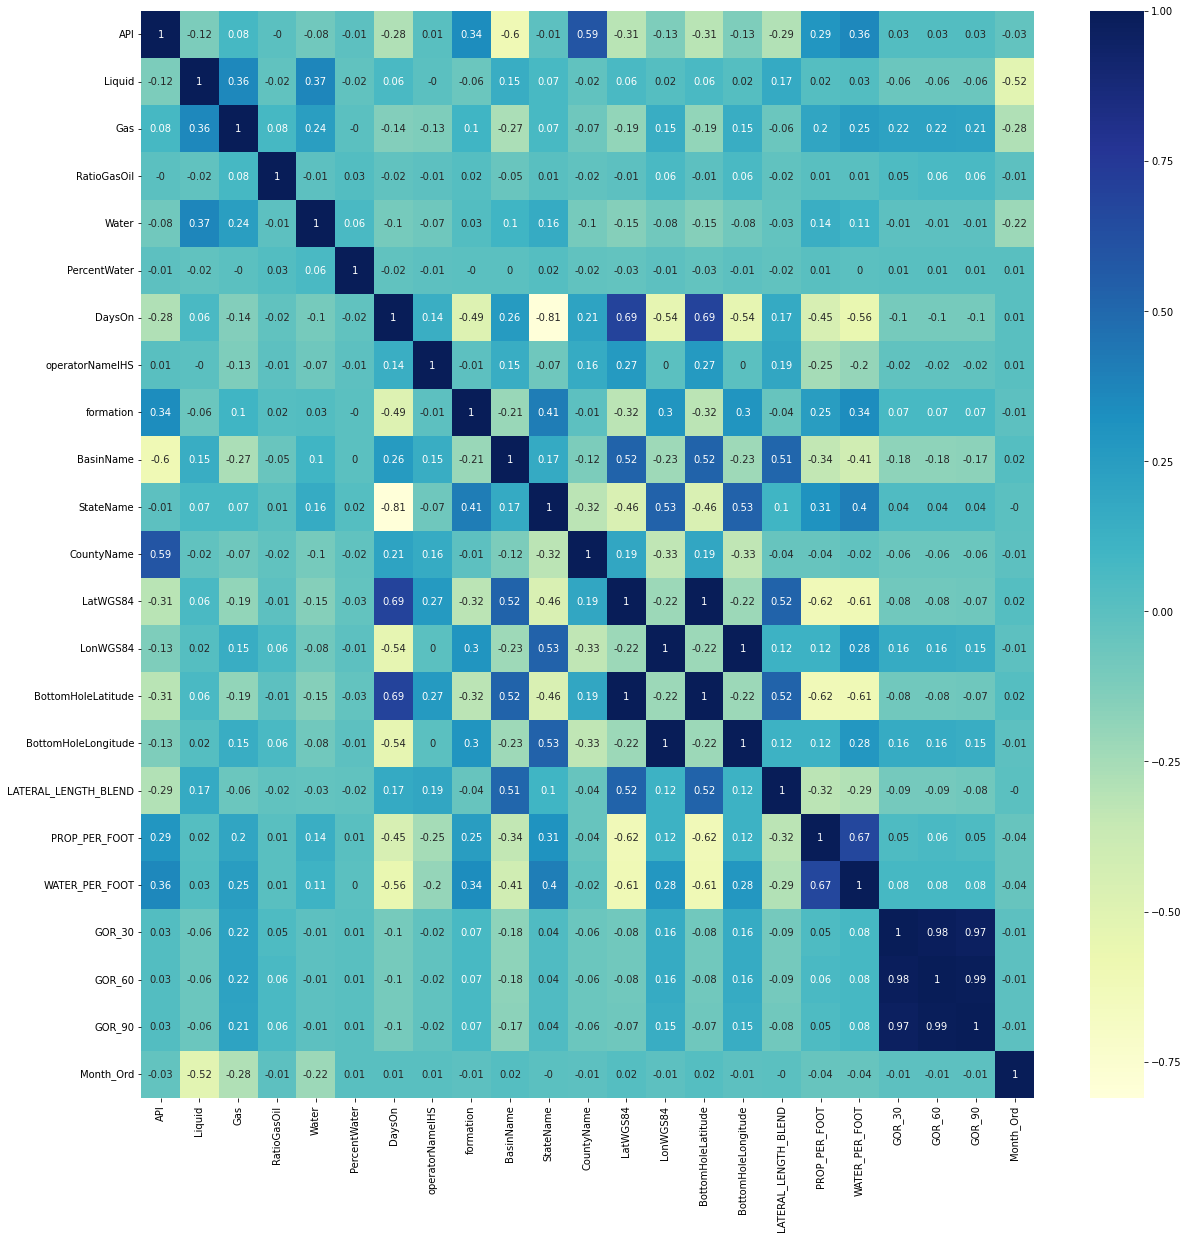

In [68]:
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(round(df_pro_ord.corr(),2), annot=True, cmap='YlGnBu');

In [69]:
df_peak = df_pro_ord.drop(['Gas', 'RatioGasOil', 'Water', 'PercentWater','DaysOn', 'operatorNameIHS',  'StateName', 
'CountyName', 'LatWGS84', 'LonWGS84', 'BottomHoleLatitude','BottomHoleLongitude', 'PROP_PER_FOOT','WATER_PER_FOOT', 'GOR_30', 'GOR_60', 'GOR_90'], axis=1)

In [70]:
train_batch = np.random.choice(df_peak.API.unique(),round(len(df_peak.API.unique())*0.8), replace=False)
df_peak_train = df_peak[df_peak.API.isin(train_batch)]
df_peak_valid = df_peak[~df_peak.API.isin(train_batch)]

In [71]:
X_train, Y_train = df_peak_train.drop('Liquid',axis=1), df_peak_train.Liquid
X_valid, Y_valid = df_peak_valid.drop('Liquid',axis=1), df_peak_valid.Liquid

In [88]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276066 entries, 2015-04-01 to 2018-12-01
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   API                   276066 non-null  int32
 1   formation             276066 non-null  int32
 2   BasinName             276066 non-null  int32
 3   LATERAL_LENGTH_BLEND  276066 non-null  int32
 4   Month_Ord             276066 non-null  int32
dtypes: int32(5)
memory usage: 7.4 MB


In [72]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.01, early_stopping_rounds=100).fit(X_train, Y_train, eval_set=[(X_train, Y_train),(X_valid, Y_valid)], verbose=50)

[0]	validation_0-rmse:4774.45958	validation_1-rmse:4864.88817
[50]	validation_0-rmse:3500.87316	validation_1-rmse:3623.67006
[100]	validation_0-rmse:2874.00804	validation_1-rmse:3018.85201
[150]	validation_0-rmse:2579.75203	validation_1-rmse:2742.60930
[200]	validation_0-rmse:2441.67667	validation_1-rmse:2619.46365
[250]	validation_0-rmse:2368.92491	validation_1-rmse:2560.84790
[300]	validation_0-rmse:2325.03951	validation_1-rmse:2528.87798
[350]	validation_0-rmse:2295.25019	validation_1-rmse:2509.89219
[400]	validation_0-rmse:2271.20858	validation_1-rmse:2498.49186
[450]	validation_0-rmse:2250.09673	validation_1-rmse:2489.76844
[500]	validation_0-rmse:2231.31155	validation_1-rmse:2481.96808
[550]	validation_0-rmse:2216.06456	validation_1-rmse:2476.68090
[600]	validation_0-rmse:2202.08167	validation_1-rmse:2471.96630
[650]	validation_0-rmse:2191.94887	validation_1-rmse:2468.47193
[700]	validation_0-rmse:2181.65212	validation_1-rmse:2466.02762
[750]	validation_0-rmse:2171.51678	validati

In [73]:
df_peak_valid['Liquid_pred'] = xgb_reg.predict(X_valid)

Well Number:5932


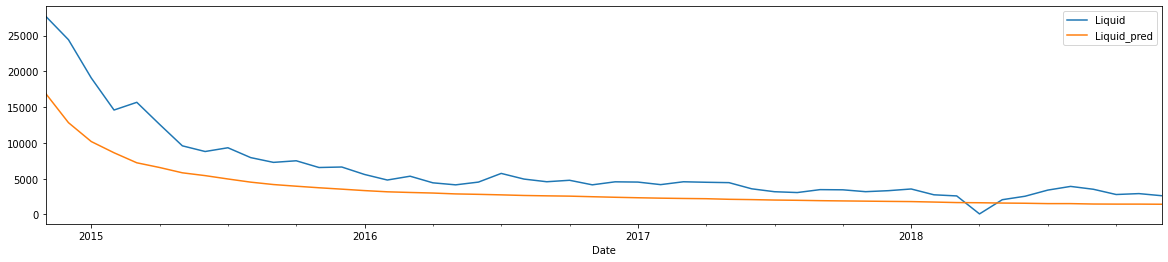

In [74]:
well = np.random.choice(df_peak_valid.API.unique(),1)[0]
df_peak_valid[df_peak_valid.API == well].Liquid.plot(figsize=(20,4))
df_peak_valid[df_peak_valid.API == well].Liquid_pred.plot()
print(f'Well Number:{well}')
plt.legend()
plt.show()

In [85]:
basins = {i:sorted(train_data.BasinName.unique())[i] for i in range(4)}

In [76]:
formations = {i : sorted(train_data.formation.unique())[i] for i in range(len(train_data.formation.unique()))}

In [77]:
df_peak['Basin_name'] = df_peak.BasinName.map(basins)
df_peak['Formation_name'] = df_peak.formation.map(formations)

In [78]:
df_peak.rename(columns={'formation':'Formation_ID', 'Liquid':'Oil', 'BasinName':'Basin_ID', 'LATERAL_LENGTH_BLEND':'Lateral_Length'}, inplace=True)

In [79]:
df_peak.to_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\API Oil Production\Datasets\Oil_prod_curve.csv')

In [87]:
pickle.dump(xgb_reg, open(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\API Oil Production\Notebooks\Oil_pred.pkl', 'wb'))